In [ ]:
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
import torchvision
from skimage.io import imread
from PIL import Image
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Mounted at /content/drive
cuda:0


In [ ]:
#Code courtesey:  https://discuss.pytorch.org/t/how-make-customised-dataset-for-semantic-segmentation/30881/6


folder_data = sorted(glob.glob("/content/drive/My Drive/CMPUT328_2020/Week08/TrainingImages/*.jpg"))
folder_mask = sorted(glob.glob("/content/drive/My Drive/CMPUT328_2020/Week08/TrainingLabels/*.jpg"))

# split these path using a certain percentage
len_data = len(folder_data)
print(len_data)
#train_size = 0.6

train_image_paths = folder_data #[:int(len_data*train_size)]
#test_image_paths = folder_data[int(len_data*train_size):]

train_mask_paths = folder_mask #[:int(len_data*train_size)]
#test_mask_paths = folder_mask[int(len_data*train_size):]

class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    def __getitem__(self, index):

        image = imread(self.image_paths[index])
        mask = torch.tensor(imread(self.target_paths[index])>100.0).long()
        t_image = self.transforms_image(image)
        return t_image, mask

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)

train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

#test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)


38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32]) torch.Size([10, 32, 32])


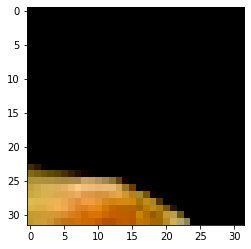

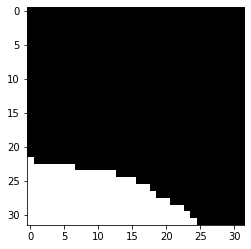

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape,example_targets.shape)

plt.imshow(example_data[0].permute(1,2,0).data)
plt.show()
plt.imshow(example_targets[0].squeeze().data,cmap="gray")
plt.show()

print(example_targets[0].squeeze().data[:])

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        self.conv3 = nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=3, stride=3)
        self.conv4 = nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=3, stride=2,output_padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = self.conv4(x).squeeze()
        return F.log_softmax(x,dim=1)

In [ ]:
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=1e-3)

for itr in range(500):
  loss_val=0.0
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.squeeze().to(device)
    optimizer.zero_grad()
    output = network(data)
    #print(output.shape,target.shape)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    loss_val += loss.item()
  if itr%10==0:
    print(loss_val)

3.1095224022865295
2.8699727058410645
2.41274493932724
1.9905159771442413
1.6125288307666779
1.3176247775554657
1.114742636680603
0.9767762720584869
0.8720711320638657
0.8062122613191605
0.727988712489605
0.6940996497869492
0.6737368628382683
0.6578033119440079
0.634262889623642
0.6127484366297722
0.5983434990048409
0.5878017097711563
0.5682378038764
0.5539423152804375
0.5643128082156181
0.5443995669484138
0.54424599558115
0.5401633828878403
0.5353843346238136
0.5305115282535553
0.5186099708080292
0.5122900828719139
0.5037210956215858
0.5225787609815598
0.5040452182292938
0.5060514286160469
0.4956621676683426
0.49178509041666985
0.49577219784259796
0.48569174110889435
0.48178885877132416
0.47635964304208755
0.4866071119904518
0.4810252860188484
0.47605836391448975
0.46960044652223587
0.46997693181037903
0.46391304582357407
0.46014678478240967
0.4622710347175598
0.45359983295202255
0.4667372480034828
0.44699376076459885
0.4563914015889168


In [ ]:

# Try trained model on flower image
flower = imread("/content/drive/My Drive/CMPUT328_2020/Week08/flower.jpg")

binary_seg = network(torch.tensor(2.0*flower/np.amax(flower)-1.0,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)).permute(1,2,0)

print(binary_seg.shape)

torch.Size([620, 944, 2])


flower image shape (427, 640, 3)
segmented image shape torch.Size([620, 944, 2])


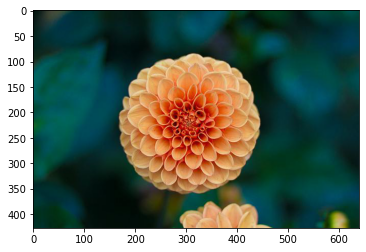

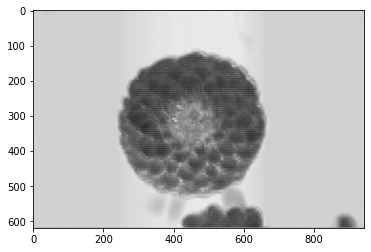

In [ ]:

print("flower image shape",flower.shape)
print("segmented image shape",binary_seg.shape)
plt.imshow(flower)
plt.show()
plt.imshow(binary_seg[:,:,0].cpu().data,cmap="gray")
plt.show()